# Investigating Airport Operations with Principal Component Analysis

Using supplied data about airport operations, we wish to conduct analysis on which factors would help poorly performing airports do better. We'll begin by using dimensionality reduction before performing K-Means clustering in order to understand the principal components and how they interact.

---

Start by importing the required libraries.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Load in the data.

In [2]:
airports = pd.read_csv('data/airport_operations.csv')
airports.head()

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


Now define our feature matrix and target variable.

In [3]:
X = airports.iloc[:, 2:15].values
y = airports.iloc[:, 0].values

Next we scale the feature matrix. Then using these standardised values we create the covariance matrix, and decompose this to get the eigenvalues and eigenvectors.

In [4]:
scaler = StandardScaler()
X_standardised = scaler.fit_transform(X)

In [5]:
cov_matrix = np.cov(X_standardised.T)
eigenValues, eigenVectors = np.linalg.eig(cov_matrix)

To obtain the Principal Components, we find the eigenpairs and sort them in descending order. 

In [6]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]

In [7]:
eigenPairs.sort()
eigenPairs.reverse()

for i in eigenPairs:
    print i[0]

6.43554590921
4.30034271686
0.84616884844
0.511389159623
0.468106590922
0.167784858101
0.120373901809
0.0875752619392
0.0642089840261
0.0102498362064
0.002859972289
0.000703167500326
0.000166983552114


Find the sum total of the eigenvalues.

In [8]:
totalEigen = sum(eigenValues)
totalEigen

13.015476190476203

Now we calculate the explained variance and the cumulative explained variance.

In [9]:
explained_variance = [100*i/totalEigen for i in sorted(eigenValues, reverse = True)]
explained_variance

[49.44533580662447,
 33.040225758332639,
 6.5012515566581746,
 3.9290852838532757,
 3.596538336907837,
 1.2891180902314221,
 0.92485207646506162,
 0.67285484340042723,
 0.49332796654079664,
 0.078751142535241112,
 0.021973627757833444,
 0.0054025491655870349,
 0.0012829615272600692]

In [10]:
cumulative_explained_variance = np.cumsum(explained_variance)
cumulative_explained_variance

array([  49.44533581,   82.48556156,   88.98681312,   92.91589841,
         96.51243674,   97.80155483,   98.72640691,   99.39926175,
         99.89258972,   99.97134086,   99.99331449,   99.99871704,  100.        ])

Here we see that 82.5% of the behaviour can be attributed to the first two principal components.

At this point we will use SciKit Learn to help perform the PCA. Now that we have an idea of how many components we need, we can plug them into the method.

In [11]:
pca = PCA(n_components = 2)
Y = pca.fit_transform(X_standardised)

Create a dataframe of the PCA results.

In [12]:
df = pd.DataFrame(Y, columns = ['PC1', 'PC2'])

Next combine this with the 'airport' and 'year' columns from the original airports data.

In [13]:
airports_2 = airports[['airport', 'year']]
airports_pca = airports_2.join(df, on = None, how = 'left')
airports_pca.head()

,airport,year,PC1,PC2
0,ABQ,2004,-2.104891,0.769690
1,ABQ,2005,-2.501786,0.700678
2,ABQ,2006,-1.947183,0.990674
3,ABQ,2007,-1.512762,0.725494
4,ABQ,2008,-2.061681,0.748124


Chart the results.

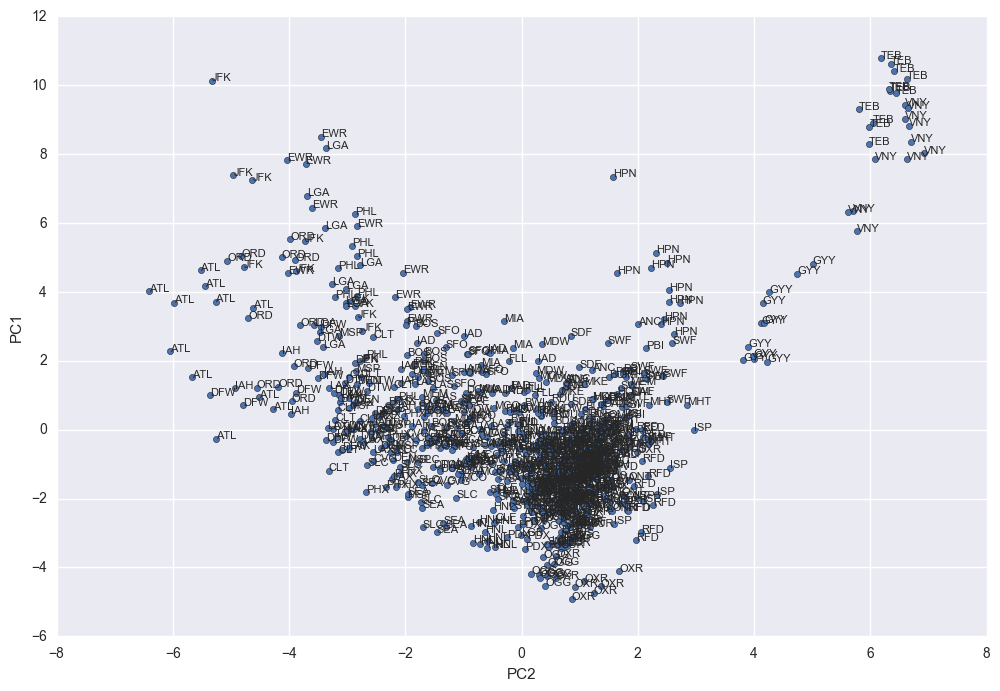

In [14]:
chart = airports_pca.plot(kind = 'scatter', x = 'PC2', y = 'PC1', figsize = (12,8))

for i, airport in enumerate(airports_pca['airport']):
    chart.annotate(airport, (airports_pca.iloc[i].PC2, airports_pca.iloc[i].PC1), fontsize = 8)

Now for the clustering. First instantiate and fit the K-Means model.

In [15]:
km = KMeans(n_clusters = 2)
clusters = km.fit(X)

Then get the labels and centroids.

In [16]:
labels = km.labels_
centroids = km.cluster_centers_

Compute the Silhouette Score.

In [17]:
silhouette_score(X, labels, metric = 'euclidean')

0.67002249074933828

Finally we add the clusters to the *airports_pca* dataframe and then plot the results.

In [18]:
airports_pca['cluster'] = labels

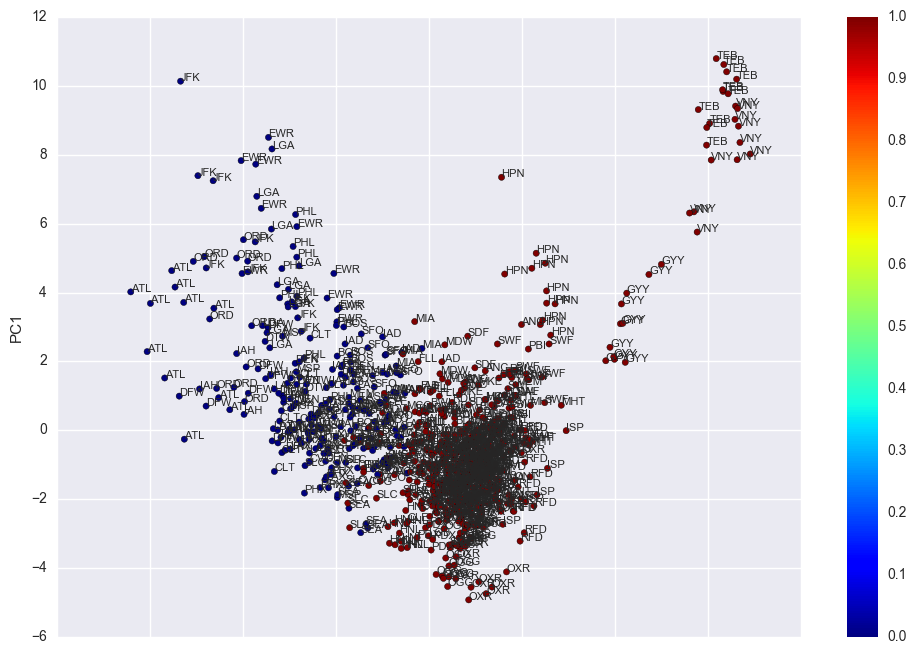

In [19]:
chart_2 = airports_pca.plot(kind = 'scatter', x = 'PC2', y = 'PC1', figsize = (12,8),
                            c = airports_pca.cluster, colormap = 'jet')

for i, airport in enumerate(airports_pca['airport']):
    chart_2.annotate(airport, (airports_pca.iloc[i].PC2, airports_pca.iloc[i].PC1), fontsize = 8)